In [10]:
"""
Visualizing Data Distributions Before & After Transformation

Dataset: retail_sales_numeria_week4.csv

What this script shows (visually + with quick stats):
1) Load + minimal cleaning (fix invalids)
2) Create transformed versions:
   - Log1p
   - Power Transform (Yeo-Johnson)
3) Visual comparisons for key skewed features:
   - Histogram overlays (Raw vs Log vs Power)
   - Boxplot comparisons
   - ECDF comparisons (great for tail behavior)
4) Print skewness + mean/median to support narration

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer


In [11]:
# -----------------------------
# 1) Load dataset
# -----------------------------
df = pd.read_csv("D:/datasets/dpp/retail_sales_numeria_week4.csv")

FEATURES = ["annual_income", "monthly_spend", "avg_basket_value", "marketing_spend"]

# -----------------------------
# 2) Minimal cleaning BEFORE visualization
# -----------------------------
df_clean = df.copy()

# Fix known invalid values in this dataset
df_clean.loc[df_clean["annual_income"] <= 0, "annual_income"] = np.nan
df_clean.loc[df_clean["marketing_spend"] < 0, "marketing_spend"] = np.nan

# Median imputation for visualization (keeps plots consistent)
for c in FEATURES:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())


In [12]:
# -----------------------------
# 3) Create transformations
# -----------------------------
# Log1p (safe for positive values)
df_log = df_clean.copy()
for c in FEATURES:
    df_log[c] = np.log1p(df_log[c])

# Power Transform (Yeo-Johnson)
pt = PowerTransformer(method="yeo-johnson", standardize=False)
df_power = df_clean.copy()
df_power[FEATURES] = pt.fit_transform(df_clean[FEATURES])



In [13]:
# -----------------------------
# 4) Quick stats table for narration
# -----------------------------
stats = []
for c in FEATURES:
    raw = df_clean[c]
    stats.append([
        c,
        raw.skew(), df_log[c].skew(), df_power[c].skew(),
        raw.mean(), raw.median()
    ])

stats_df = pd.DataFrame(
    stats,
    columns=["feature", "skew_raw", "skew_log1p", "skew_powerYJ", "mean_raw", "median_raw"]
).round(3)

print("\nFeature diagnostics (raw mean/median + skewness comparisons):")
print(stats_df.to_string(index=False))



Feature diagnostics (raw mean/median + skewness comparisons):
         feature  skew_raw  skew_log1p  skew_powerYJ  mean_raw  median_raw
   annual_income     4.078      -0.044          -0.0 59290.383   36890.950
   monthly_spend     5.010       0.025          -0.0  8209.064    4927.110
avg_basket_value     2.597       0.000           0.0   189.492     147.219
 marketing_spend     5.597       0.028          -0.0   821.475     499.943


In [17]:
# -----------------------------
# 5) Plot helpers
# -----------------------------
def plot_hist_overlay(col: str, bins: int = 40):
    """Histogram overlay: Raw vs Log1p vs Power(YJ)."""
    plt.figure(figsize=(9, 4))
    #plt.hist(df_clean[col], bins=bins, alpha=0.55, label="Raw (cleaned)")
    plt.hist(df_log[col], bins=bins, alpha=0.55, label="Log1p")
    plt.hist(df_power[col], bins=bins, alpha=0.55, label="Power (Yeo-Johnson)")
    plt.title(f"Histogram Overlay — Before vs After: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_box_compare(col: str):
    """Boxplot comparison: shows outlier compression effect."""
    plt.figure(figsize=(7, 4))
    plt.boxplot(
        [df_clean[col].values, df_log[col].values, df_power[col].values],
        tick_labels=["Raw", "Log1p", "Power(YJ)"],
        showfliers=True
    )
    plt.title(f"Boxplot Comparison — Outlier Impact: {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

def plot_ecdf_compare(col: str):
    """ECDF comparison: great for showing how tails compress."""
    def ecdf(x):
        x = np.sort(x)
        y = np.arange(1, len(x) + 1) / len(x)
        return x, y

    x_raw, y_raw = ecdf(df_clean[col].values)
    x_log, y_log = ecdf(df_log[col].values)
    x_pow, y_pow = ecdf(df_power[col].values)

    plt.figure(figsize=(8, 4.5))
    #plt.plot(x_raw, y_raw, label="Raw (cleaned)")
    plt.plot(x_log, y_log, label="Log1p")
    plt.plot(x_pow, y_pow, label="Power (YJ)")
    plt.title(f"ECDF Comparison — Tail Behavior: {col}")
    plt.xlabel(col)
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.tight_layout()
    plt.show()



--- Visualizing feature: annual_income ---


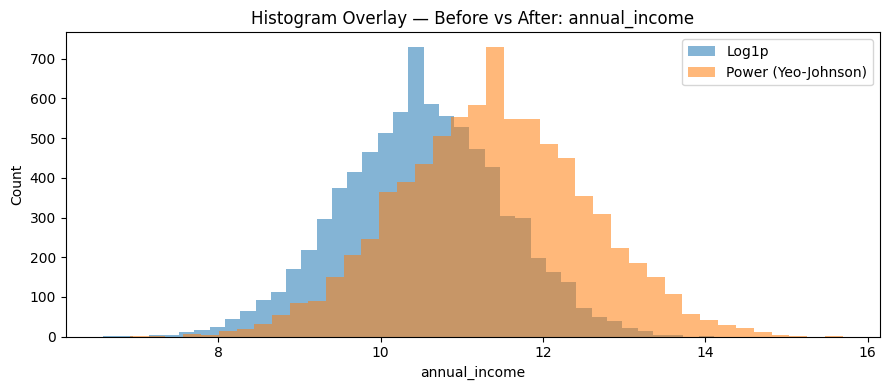

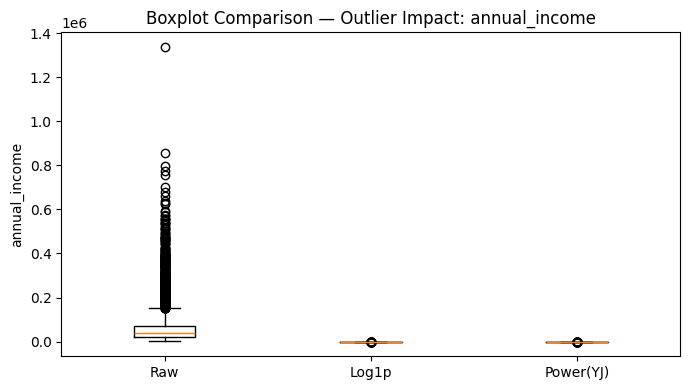

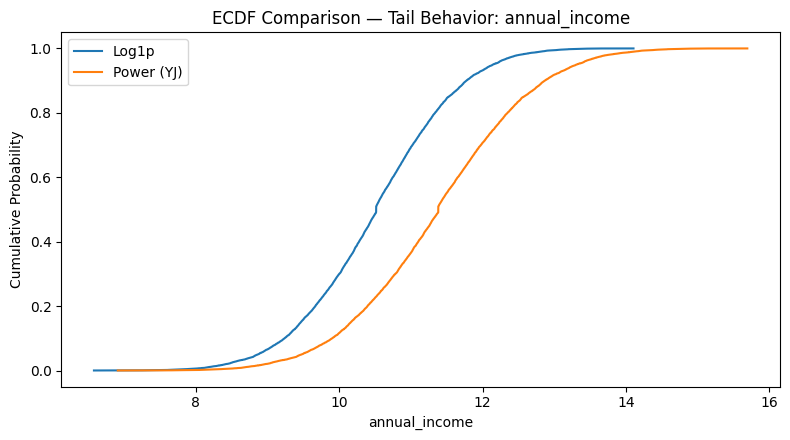


--- Visualizing feature: monthly_spend ---


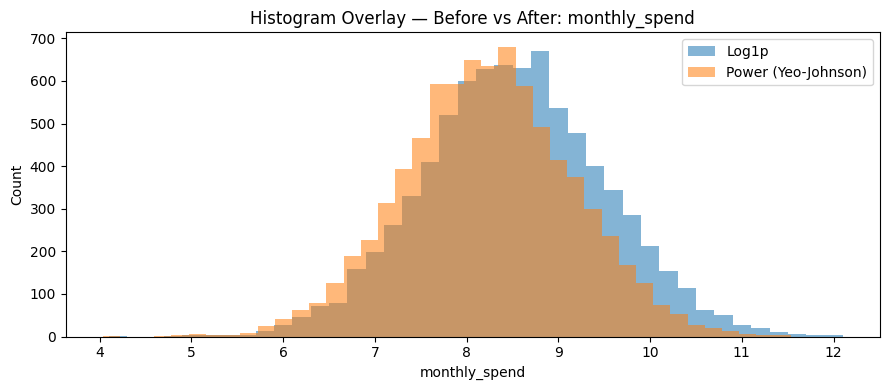

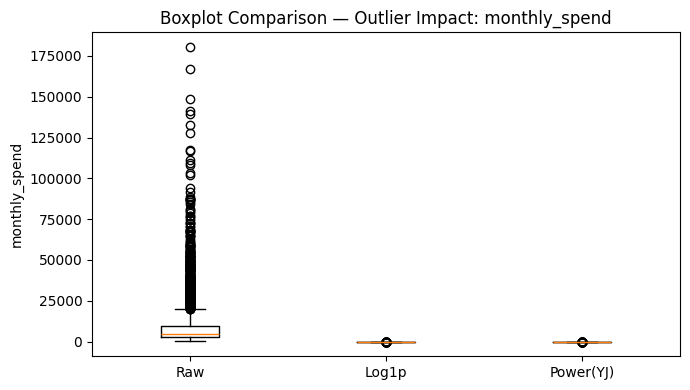

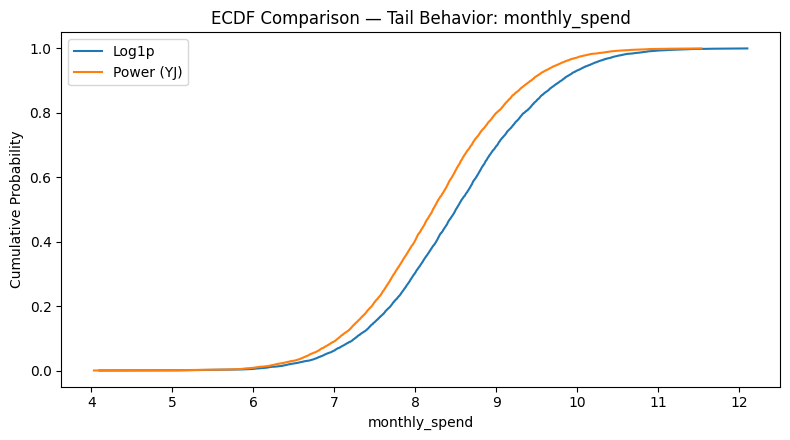


--- Visualizing feature: avg_basket_value ---


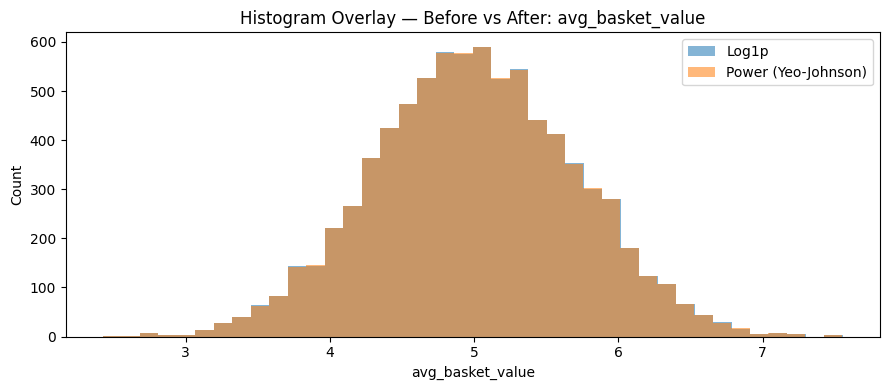

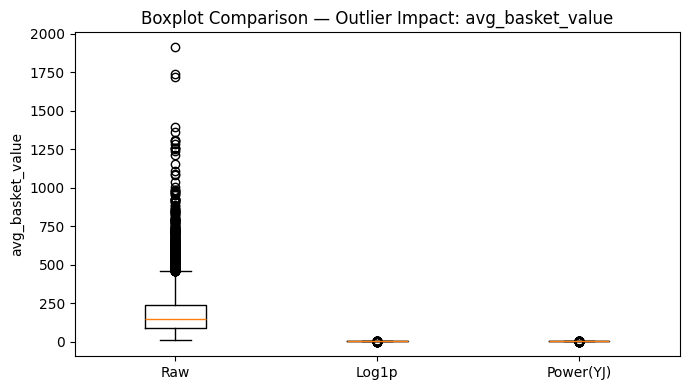

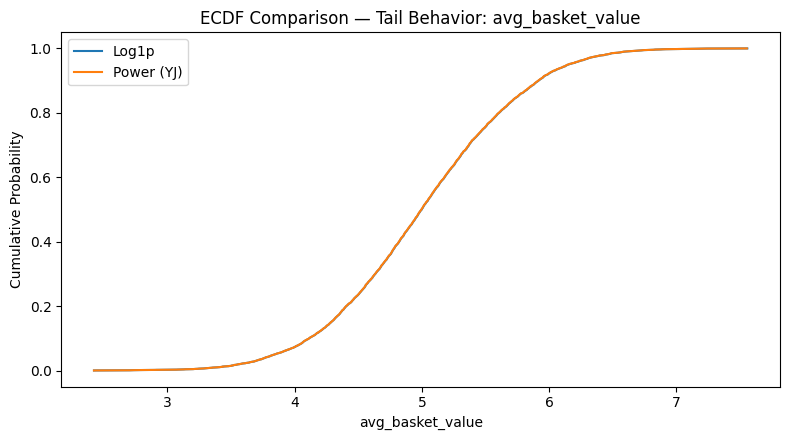


--- Visualizing feature: marketing_spend ---


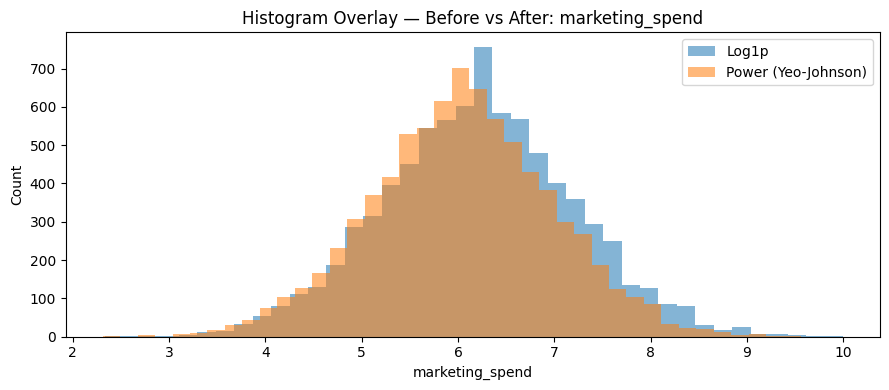

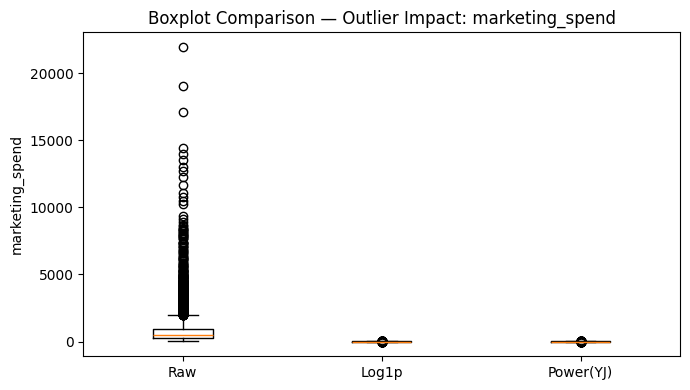

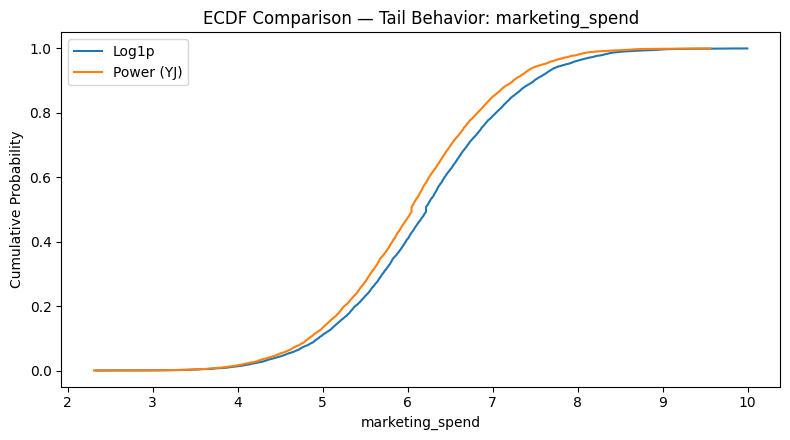

In [18]:
# -----------------------------
# 6) Run visualizations feature-by-feature
# -----------------------------
for c in FEATURES:
    print(f"\n--- Visualizing feature: {c} ---")
    plot_hist_overlay(c)
    plot_box_compare(c)
    plot_ecdf_compare(c)
